

> # Burada Gerekli Kütüphaneleri colab'ın bize verdiği device içerisine kuruyoruz



In [ ]:
!pip install rdkit-pypi==2022.9.5
!pip install pandas==1.5.3
!pip install Pillow==9.4.0
!pip install matplotlib==3.6.3
!pip install pydot==1.4.2
!sudo apt-get -qq install graphviz
!pip install tensorflow==2.12.0


  Using cached matplotlib-3.6.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached matplotlib-3.6.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)




> # Kütüphanelerin import edilmesi



In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
import matplotlib
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print(matplotlib.__version__)

3.6.3



> # Veriseti Okuma

Burada benim github hesabıma bağlanarak verisetini çekip bir pandas dataframe haline getiriyoruz

158661/158661 [==============================] - 0s 0us/step


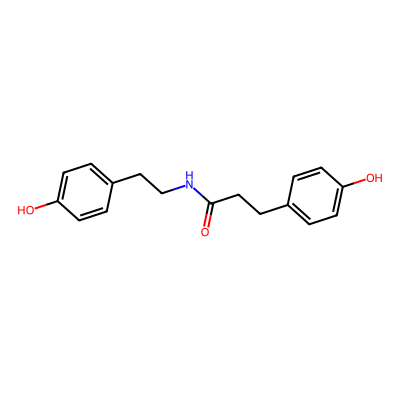

In [ ]:

csv_path = keras.utils.get_file(
    "HIV7.csv", "https://raw.githubusercontent.com/McahitKutsal/hivcsv/main/HIV7.csv"
)


df = pd.read_csv(csv_path)
sample = df["smiles"][100:101].values
molecules = [Chem.MolFromSmiles(smiles) for smiles in sample]
grid = MolsToGridImage(molecules, molsPerRow=1, subImgSize=(400,400))
df["smiles"][100:101].values
grid



```
# Bu, kod` olarak biçimlendirilmiştir`
```

# Öznitelik Tanımlamaları
Burada atom ve bağ özniteliklerini tanımladığımız AtomFeaturizer ve BondFeaturizer Class'larını tanımlıyoruz

In [ ]:
class Featurizer:
    # istediğimiz özellikleri $allowable_sets dictionary değişkeninde göndereceğiz
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    # Element simgesi
    # def symbol(self, atom):
    #   return atom.GetSymbol()
    # Değerlik elektron sayısı bir elementin atomlarının oluşturabildiği kimyasal bağların sayısına denir.
    # Başka bir deyişle bir elementin birleşme yeteneğinin ölçüsüdür.
    def n_valence(self, atom):
        return atom.GetTotalValence()
    """"""
    def n_number(self, atom):
        return atom.GetAtomicNum()

    def n_degree(self, atom):
        return atom.GetDegree()

    # def formal_charge(self, atom):
    #     return atom.GetFormalCharge()

    def is_aromatic(self, atom):
        return atom.GetIsAromatic()

    def n_radical_electrons(self, atom):
        return atom.GetNumRadicalElectrons()

    def is_in_ring(self, atom):
        return atom.IsInRing()

    # def chiral_tag(self, atom):
    #     return atom.GetChiralTag().name.lower()
    """"""
    # Molekül'ün sahip olduğu hidrojen sayısı
    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    # Hibridizasyon, bir atomun farklı orbitallerinin aynı hibrit orbitalleri oluşturduğu kimyasal bir süreçtir.
    # s, sp, sp2, sp3 Şeklinde olabilir
    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    # Kimyasal bağ, atomları birbirine bağlayan ve bir arada kalmalarını sağlayan kuvvettir
    # Tekli, çiftli, üçlü veya aromatik olabilir
    def bond_type(self, bond):
        return bond.GetBondType().name.lower()


    # Kimyada konjuge bir sistem, genel olarak molekülün genel enerjisini düşüren ve stabiliteyi arttıran bir p-orbitaller sistemidir.
    def conjugated(self, bond):
        return bond.GetIsConjugated()


# Generate ettiğimiz Class'ların örneklerini oluşturuyoruz
atom_featurizer = AtomFeaturizer(
    allowable_sets={
       #  "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_number" : {1, 5, 6, 8, 9, 11, 15, 16, 17, 20, 35, 53},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
        "n_degree": {0, 1, 2, 3, 4, 5, 6},
        # "formal_charge": {-2, -1, 0, 1, 2},
        "n_radical_electrons": {0, 1, 2, 3, 4},
        "is_in_ring": {True, False},
        # "chiral_tag": {"chi_tetrahedral_cw", "chi_tetrahedral_ccw"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)



> # !!! Önemli: burada elimizdeki verisetini tensorflow ile kuracağımız geometrik derin öğrenme mimarsinin anlayacağı hale getiriyoruz



In [ ]:

# RdKit kütüphanesi ile smiles string'ten molecule nesnesine geçiş yapıyoruz
def molecule_from_smiles(smiles):
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)
    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

# Şimdi molekül nesnesinden kuracağımız derin öğrenme mimarisinin okuyabileceği graph veri yapısına geçiş yapıyoruz
def graph_from_molecule(molecule):
    # graph'ı boş şekilde başlatıyoruz
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Burası çok önemli !!!
        # Burada oluşturulacak graph versinin komşuluk matrisindeki diagonal'ı tamamen 1 yapıyoruz
        # çünkü message passing adımında ger bir node için kendi bilgisi de oluşturulacak "message'a" eklenmeli
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)

# Yukarıda ki sınıfın hemen hemen aynısı burada smiles string'ten direkt graph veri yapısına geçiş yapıyoruz
def graphs_from_smiles(smiles_list):
    # graph'ları boş şekilde başlatıyoruz
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        # smiles'tan molecüle geçiş
        molecule = molecule_from_smiles(smiles)
        # molekül'den graph'a geçiş
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Listeler ragged tensor'lerine çeviriliyor daha sonra tf.data.Dataset olarak kullanmak için
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


# dataframe karıştırılıyor
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# 80% train
train_index = permuted_indices[: int(df.shape[0] * 0.80)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].HIV_active

# 19% validation
valid_index = permuted_indices[int(df.shape[0] * 0.80) : int(df.shape[0] * 0.95)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].HIV_active

# 10% test
test_index = permuted_indices[int(df.shape[0] * 0.95) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].HIV_active



> # Bu bölümde veri setini neural network'te verimli bir şekilde işletebileceğimiz batch'ler haline getiriyoruz.



In [ ]:
def prepare_batch(x_batch, y_batch):

    atom_features, bond_features, pair_indices = x_batch

    # her bir graph için atom ve bağ sayısını alıyoruz
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)


    # elde edilen bu subgraph'ları global bir graph'ta bileştiriyoruz
    # burda her bir subgraph diğerlerinden ayrılmıştır
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()


    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch

# şimdi yukarıda tanımlanan fonksiyonu burada dekoratör tasarım kalıbına benzer şekilde aşağıdaki fonksiyonun return ifadesindeki map() fonksiyonuna geçiyoruz
# böylece X, y parametrelerini de prepare_batch() fonksiyonuna geçilmiş oluyor.
# böylelikle verisetiminizi elde edeceğimiz fonksiyonu ileride kullanabileceğiz
def MPNNDataset(X, y, batch_size=48, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)



> # Şimdi neural network'ü oluşturmaya başlıyoruz
Oluşturacağımız neural network bit MPNN modelidir. Yazacağımız MPNN modeli 3 kısımdan oluşuyor bunlar message passing, readout, ve classification.

**Message passing** adımının kendisi iki bölümden oluşur:

1- **Edge Network :** Komşu node'lardan gelen mesajları edge feature'lara bağlı olarak embedding'i hesaplanan node'a iletir.

2- **The gated recurrent unit (GRU)**: Bir düğümün en son durumunu girdi olarak alır ve bu düğümü kendisinin önceki durumlarına göre günceller, yani bir düğümün var olan durumu GRU'da girdi olarak kullanılırken önceki durumlar bellekte tutularak işlem yapılır, bu yapı **RNN**'e oldukça benzemektedir.



In [ ]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs


        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])


        for i in range(self.steps):

            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )


            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated




> # **Readout**:

 Message passing adımı bittiğinde prepare_batch() fonksiyonunda merge ettiğimiz molekülleri tekrar ayırıyoruz.
 Burada bazı önemli işlemler var hocam hatırlarsanız üst section'larda neural network'e verebilmek için graph'ları batch haline getirmiştik yani basitçe birleştirmiştik, burada o birleşen graplar'ı ayırıyoruz ve dolguluyoruz dolgulama işlemini aşağıda dolgulama yaptığımız yerde açıkladım, daha sonra dolguların eğitimi engellemediğinden emin olmak için en son olarak maskeleme işlemi yapıyoruz.




In [ ]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # subgraph'ları batch içerisinden geri ayıklıyoruz
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # bu adımı tezde açıklasam daha iyi olacak hocam
        # burda basitçe elde edilen subraph'lar şişirilip(yani en yüksek node sayısına sahip olan graph ile node sayısı eşitlenecek şekilde) stack haline getiriliyor
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Batch sayısına bağlı olarak bazı subgraph'lar boş gelebilir onları çıkarmamız gerekiyor onu burada yapıyoruz
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)

# son olarak, tensör Transformer'dan geçirilir ve ardından ortalama havuzlama yapılır.
class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=92, dense_dim=92, batch_size=48, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.max_pooling = layers.GlobalMaxPooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.max_pooling(proj_output)

In [ ]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def npv(y_actual, y_pred):

    negative_value = 1.

    if y_pred.shape[-1]==2: # last activation: softmax for binary classification
        y_actual = tf.cast(tf.argmax(y_actual, -1), tf.float32) # get true class
        y_pred = tf.cast(tf.argmax(y_pred, -1), tf.float32) # get pred class

    else: # last activation: sigmoid for binary classification
        y_pred = tf.round(y_pred) # round probability

    # if (y_pred == negative_value) and (y_pred == negative_value)
    tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, negative_value),
                                              tf.equal(y_pred, y_actual)), tf.float32))
    # if (y_pred == negative_value) and (y_pred != negative_value)
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, negative_value),
                                              tf.not_equal(y_pred, y_actual)), tf.float32))

    result = tn / ((tn + fn) + K.epsilon()) # add epsilon to avoid nan
    return result



> # MPNN

Bu section'da MPNN modelimizi kuruyoruz **message passing** ve **readout** adımlarına ek olarak 2 adet **dense** layer'ı daha eklendi



In [ ]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=48,
    message_units=92,
    message_steps=10,
    num_attention_heads=8,
    dense_units=92,
):


    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(dense_units//2, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(dense_units//4, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[keras.metrics.AUC(name="AUC"),keras.metrics.BinaryAccuracy(name="accuracy", dtype=None, threshold=0.5), f1, npv, keras.metrics.Precision(), tf.keras.metrics.SensitivityAtSpecificity(0.5)]
)




 > # Eğitime başlıyoruz ve modelin doğruluk metriklerini hesaplıyoruz



In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

In [ ]:
history = mpnn.fit(train_dataset, validation_data=valid_dataset, epochs=60, verbose=1)

Epoch 1/60
49/49 [==============================] - 29s 484ms/step - loss: 0.6699 - AUC: 0.6248 - accuracy: 0.5901 - f1: 0.5971 - npv: 0.5870 - precision: 0.5917 - sensitivity_at_specificity: 0.6568 - val_loss: 0.6029 - val_AUC: 0.7889 - val_accuracy: 0.6944 - val_f1: 0.7268 - val_npv: 0.6711 - val_precision: 0.6754 - val_sensitivity_at_specificity: 0.8451
Epoch 2/60
49/49 [==============================] - 22s 454ms/step - loss: 0.6197 - AUC: 0.7138 - accuracy: 0.6464 - f1: 0.6426 - npv: 0.6373 - precision: 0.6481 - sensitivity_at_specificity: 0.7774 - val_loss: 0.5672 - val_AUC: 0.8260 - val_accuracy: 0.7407 - val_f1: 0.7603 - val_npv: 0.7095 - val_precision: 0.7192 - val_sensitivity_at_specificity: 0.8761
Epoch 3/60
49/49 [==============================] - 22s 452ms/step - loss: 0.5934 - AUC: 0.7525 - accuracy: 0.6781 - f1: 0.6830 - npv: 0.6819 - precision: 0.6782 - sensitivity_at_specificity: 0.8190 - val_loss: 0.5494 - val_AUC: 0.8455 - val_accuracy: 0.7685 - val_f1: 0.7579 - val_

In [ ]:
y_pred_keras = mpnn.predict(test_dataset)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

4/4 [==============================] - 2s 144ms/step


In [ ]:
auc_keras

0.9316190476190477


> # Doğruluk metriklerinin grafik haline getirilmesi (Üzerinde çalışıyorum)



KeyError: 'precision_4'

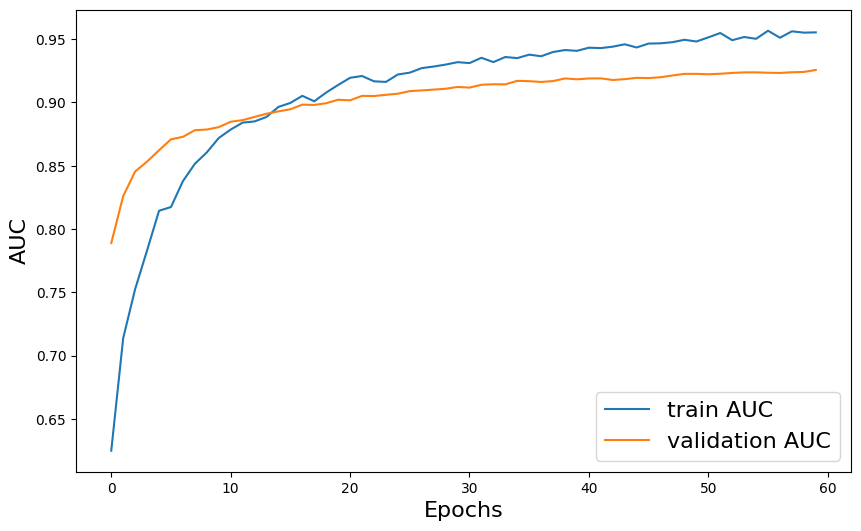

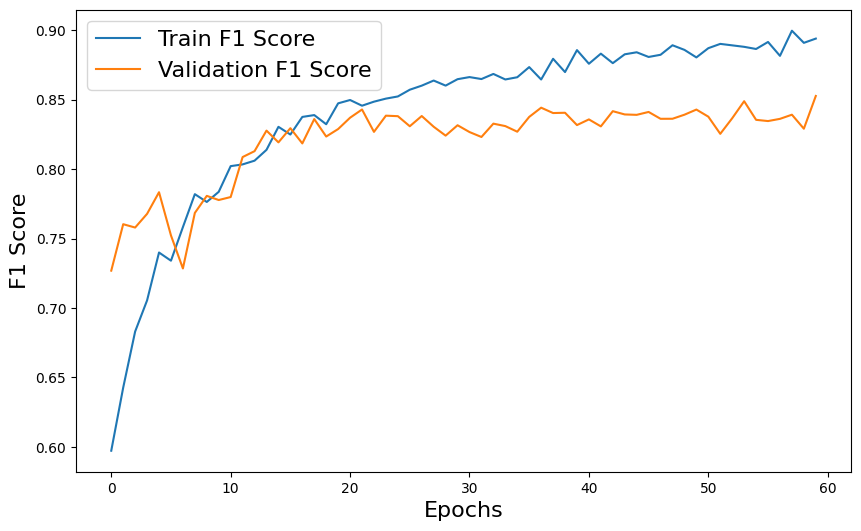

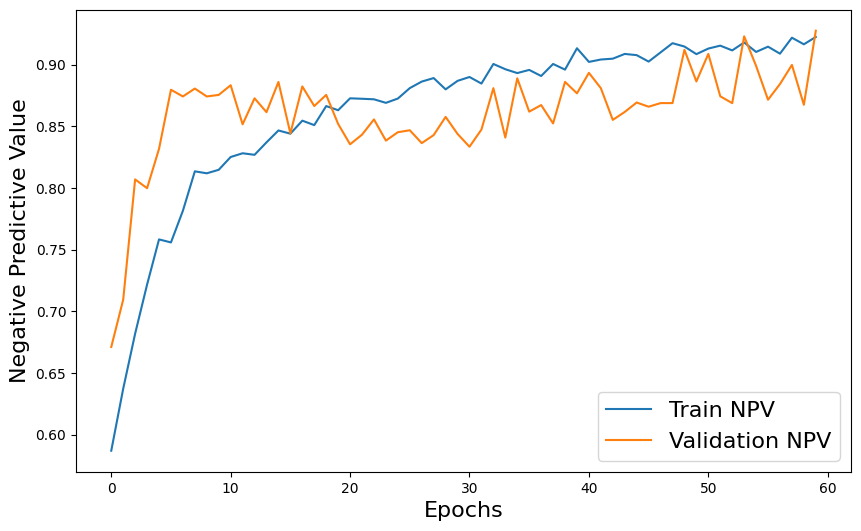

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="validation AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

plt.figure(figsize=(10, 6))
plt.plot(history.history["f1"], label="Train F1 Score")
plt.plot(history.history["val_f1"], label="Validation F1 Score")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("F1 Score", fontsize=16)
plt.legend(fontsize=16)


plt.figure(figsize=(10, 6))
plt.plot(history.history["npv"], label="Train NPV")
plt.plot(history.history["val_npv"], label="Validation NPV")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Negative Predictive Value", fontsize=16)
plt.legend(fontsize=16)

plt.figure(figsize=(10, 6))
plt.plot(history.history["precision_4"], label="Train PPV")
plt.plot(history.history["val_precision_4"], label="Validation PPV")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Positive Predictive Value", fontsize=16)
plt.legend(fontsize=16)

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


> # Eğitilmiş modelle yapılan birkaç tahmin




4/4 [==============================] - 1s 142ms/step


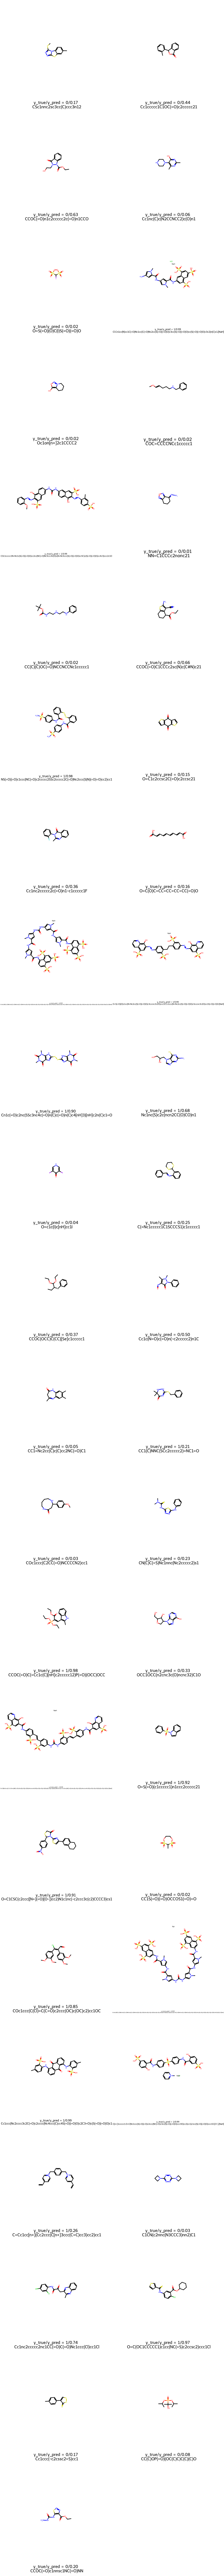

In [ ]:
molecules = [molecule_from_smiles(df.smiles.values[index])for index in test_index]
smiles = [df.smiles.values[index] for index in test_index]
y_true = [df.HIV_active.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f} \n {smiles[i]}" for i in range(100,145)]
MolsToGridImage(molecules[100:145], molsPerRow=2, legends=legends, subImgSize=(400, 400))

In [ ]:
generated_smiles = ['O=[N+]([O-])c1ccccc1S(=O)(=O)c1ccccc1',
                    'Cn1c(Nc2ccccc2)ncc1OCP(=O)(O)OC1COC(n2cc(C)c(=O)[nH]c2=O)CC1N=[N+]=[N-]',
                    'O=C(Cc1ccc(O)cc1)NCCCc1cccc(O)c1',
                    'O=[N+]([O-])c1ccccc1S(=O)(=O)c1ccccc1',
                    'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)C1COC(n2cc(C)c(=O)[nH]c2=O)CC1N=[N+]=[N-]',
                    'COc1ccccc1C(=S)Nc1ccc(Cl)c(C(=O)OC(C)(C)C)c1',
                    'O=C(O)c1ccccc1[N+](=O)[O-]',
                    'N#CC(=O)NC(=O)CCC=CC1C(=O)C(=O)NCC(=S)NNC(=S)CS1C',
                    'COC(=O)NC(=O)NC(=S)Nc1ccccc1',
                    'O=[N+]([O-])c1ccccc1S(=O)(=O)c1ccccc1']

In [ ]:
generated_smiles = ['O=C1N(NS(=O)(=O)CCCCC2=CCC=C2OC)C1=O',
 'Cc1nn(C(=O)Cc2ccccc2)c2c1C(c1ccc(O)cc1)SC(=N)N2',
 'COC(=O)c1cc(C)nc(C#N)=CCC(C)CCC1O']

In [ ]:
generated_smiles2 = ["Cc1nn(C(=O)Cc2ccccc2)c2c1C(c1ccc(O)cc1)SC(=N)N2", 'COc1ccc(NC(C)=CCC2CCC(CO)C2)c(=O)[nH]c1=O',
 'Nc1ccc(C(=O)Nc2ccc(Cl)cc2)cc1C(=O)NC(C)=O', 'C[S+](=O)c1ccccc1C(=O)Nc1ccccc1[N+](=O)[O-]']



In [ ]:
gnn=[
 'CSC1=C2C3=C1S1=S2C=C2OC(=CC=CSS2)C=C31',
 'C1=CCCc2c3c4c5cn6c(cccc6c=3c2ccc5=4)=C1',
 'S=S12=[SH]34[SH]5[SH]=N1S23C54Cl',
 'CC1=ISS23C4=[SH]12[SH]43',
 'SS12C3=S(CCl)S1=N32',

 'CC1N[N+]12OS[O-]2',
 'NN1C=C1[IH]C=S',
 'F[SH]12=O[SH]1N2Cl',
 'CC12S[SH]1(=O)[SH]=[SH]2',
 'CC1N[N+]1([O-])O',
 'ClC1[IH][SH]12=IS2',
 'S=C1O=S1[IH]CCl',
 'C=CN=C1OC1C',
 'CC12=IC(=I1)[SH]=[SH]2',
 'CC12[IH]I13=I#[SH]23',
 'C=C1C=C(O)C(O)=C1CN',
 'CCCC1=C=C=[SH]C=CC=C1C',
 'Cl[SH]123[SH]4I15=I42I53',
 'CN=[PH]1C=C1C',
 'NC1=NC(=[IH])SCl1',

 'c1c(=O)ccc1S(=O)(=O)c1ccccc1',
 'c1c(Nc2ccccc2)cc1'

 ]

In [ ]:
lstm_last = [
    'COc1ccc(-c2cc(F)c(Cl)cc2C(=O)CCC1)SC(C)=O',
    'Cc1c(O)cccc1S(=O)(=O)c1ccc(Cl)c(Cl)c1O',
    'Cc1c(O)cccc1S(=O)(=O)c1ccc(C=Cc2ccccc2)N1',
    'Cc1cc(O)cc(NC(=O)NC(=O)Nc2ccccc2)ccc1O',
    'C=C(O)c1cc(Cl)cc(O)c1C(=O)N1CCCCC2CCCC12',

    'Cc1cc(C(=O)CC=CCCCCCC=CCO)c(O)c(=O)[nH]c1=O',
    'Cc1cc(O)ccc1S(=O)(=O)c1ccc(Cl)c(C(=O)O)c1',
    'Cc1cc(Nc2cc(C)c(C(=O)O)ccc(C(=O)O)c2)c1O',
    'Cc1cc(-c2ccc(N)cc(S(=O)(=O)O)cc2)ccc1Cl',
    'n1c(=O)c2ccccc2c1CCc1cc(S(=O)(=O)O)ccc1N',


    'COc1ccc(OC2CC(C)(C)C(C(O)O)C2)cc(Cl)c(O)c1',

    'Cc1cc(=O)c(=O)NOC(=O)c(c2)c(c2)c(O)ccc1O',
    'Cc1cc(S(=O)(=O)Nc2nc(C)c(S)ccc12)OC(C)C',
    'Cc1cc(N2)c(O)c(O)c1OC(C)(O)C(O)C1CCC12C',

]


In [ ]:
lstm_last_kl_loss = ['CCNC(NCC=O)C(C)N1CCCCN1',
 'N=S(=O)(cccccc1)SCN1',
 'Oc1nc(-c2cnccc2O)c1',
 'CCCN=Cc1ccccc1OC(=O)c1ccccc1',
 'CN(C)SS(=O)(=O)c1ccccc1Cl',
 'Cc1ccc(S(=O)(=O)Nc2ccc([N+](=O)[O-])cc1)OC2',
 'CCC(=O)CS(=O)(=O)c1cc(c2cc(O)c(C)c21)O',
 'CC(C)C(=N)Nc1cc(N)c(C)c(S(=O)(=O)O)c1',
 'CCCP(=O)c1c(NC)(C(=S)COc1)c1(C)CCCC1',
 'C#CSSC(=S)NCC=SSC(=O)O']

In [ ]:
from rdkit.Chem import Descriptors
mol = Chem.MolFromSmiles('C[S+](=O)c1ccccc1C(=O)Nc1ccccc1[N+](=O)[O-]')
hDonorNum = Chem.Lipinski.NumHDonors(mol)
hAcceptorNum = Chem.Lipinski.NumHAcceptors(mol)
logp = Descriptors.MolLogP(mol)
mol_weight = Descriptors.MolWt(mol)
print(f'donor: {hDonorNum}, acceptor: {hAcceptorNum}, logp: {logp}, molweight: {mol_weight}')
if hDonorNum <=5 and hAcceptorNum <= 10 and mol_weight <500 and logp <=5:
  print("true")

donor: 1, acceptor: 4, logp: 2.7996000000000008, molweight: 304.32700000000006
true


In [ ]:
generated_graphs = graphs_from_smiles(lstm_last_kl_loss)
generated_targets = pd.Series([1 for i in range(len(lstm_last_kl_loss))])

In [ ]:
generated_dataset = MPNNDataset(generated_graphs, generated_targets)

In [ ]:
y_pred = mpnn.predict(generated_dataset)

1/1 [==============================] - 0s 91ms/step


In [ ]:
y_pred

array([[0.0293802 ],
       [0.03034426],
       [0.05699236],
       [0.15883031],
       [0.21353693],
       [0.3025323 ],
       [0.96064216],
       [0.95278656],
       [0.42298633],
       [0.06454064]], dtype=float32)

In [ ]:
[ i for i in y_pred if i > 0.50]

[array([0.96064216], dtype=float32), array([0.95278656], dtype=float32)]

1/1 [==============================] - 0s 105ms/step


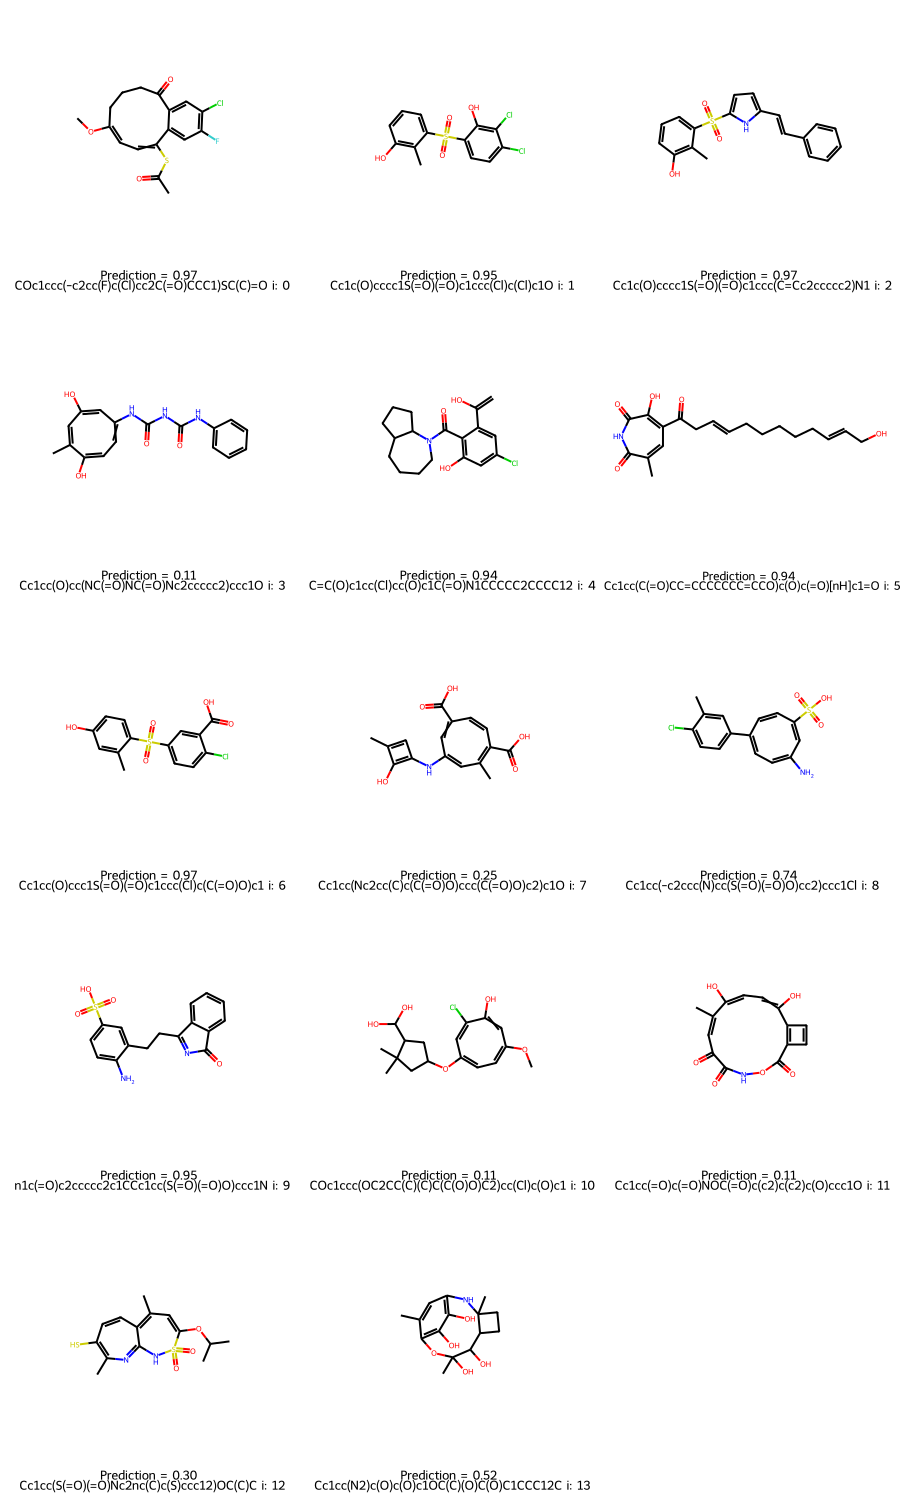

In [ ]:
# Generate graphs for lstm_last smiles
lstm_last_graphs = graphs_from_smiles(lstm_last)
lstm_last_targets = pd.Series([1 for i in range(len(lstm_last))])
lstm_last_dataset = MPNNDataset(lstm_last_graphs, lstm_last_targets)

# Predict using the generated dataset
y_pred_lstm_last = mpnn.predict(lstm_last_dataset)

# Generate molecules and legends
mols = [Chem.MolFromSmiles(i) for i in lstm_last]
legends = [f"Prediction = {y_pred_lstm_last[i][0]:.2f} \n\n {lstm_last[i]} i: {i}" for i in range(len(lstm_last))]

# Display the molecules with legends
MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), legends=legends)